# Extended Research Project Model Development (CNN)

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 395.9/395.9 kB 12.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 242.7/242.7 kB 16.5 MB/s eta 0:00:00


## 1. Preprocess the data

In [3]:
# === Step 0: Import Libraries ===
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score, f1_score, precision_score, recall_score, confusion_matrix
import pandas as pd
import numpy as np
import optuna
import joblib
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder

In [4]:
# === Step 1: Data Preparation ===
# load the data
df = pd.read_csv("/content/drive/MyDrive/ERP/CNN/Final_dl.csv.gz", compression="gzip")

df

,net_income_usd,total_assets_usd,shareholders_funds_usd,capital_usd,revenue_usd,schooling_years_2020,urban_pop_growth_2022,logistics_index_2018,life_expectancy_2022,female_labor_participation_2023,...,accounting_template,dm_gender,wb_category,accounting_template_missing,website_exists,description_exists,duo_bvd_id_exists,dm_gender_missing,capital_usd_missing,shareholders_funds_usd_missing
0,9.447491e+05,0.181549,NaN,-0.003279,3.541786e+06,1.186760,-1.189779,-0.492681,-0.677844,1.057754,...,0,2,0,1,0,1,0,1,0,0
1,1.765783e+04,0.181549,0.098608,0.040249,1.437969e+06,1.186760,-1.189779,-0.492681,-0.677844,1.057754,...,0,2,0,1,0,1,0,1,0,0
2,-2.502728e+04,0.181549,-0.168453,0.040249,1.246335e+06,1.186760,-1.189779,-0.492681,-0.677844,1.057754,...,0,2,0,1,1,1,1,1,0,0
3,1.023630e+03,0.181549,0.020692,0.028005,7.675140e+05,1.186760,-1.189779,-0.492681,-0.677844,1.057754,...,0,2,0,1,0,1,0,1,0,0
4,6.034728e+02,0.181549,0.013782,0.028005,7.037159e+05,1.186760,-1.189779,-0.492681,-0.677844,1.057754,...,0,2,0,1,0,1,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
477072,-9.593861e+03,0.181549,0.188289,0.040249,-7.980458e+03,-2.574365,2.371344,-1.654855,-1.126116,-1.398460,...,0,1,1,0,0,0,0,0,0,0
477073,-1.343988e+04,-0.028028,-0.004174,0.040249,-1.343954e+04,-2.574365,2.371344,-1.654855,-1.126116,-1.398460,...,0,1,1,0,0,0,1,0,0,0
477074,-1.027999e+05,0.181549,0.126416,0.040249,-9.145863e+04,-0.702729,0.619942,0.842805,0.877332,-0.384113,...,0,1,1,0,0,0,0,0,1,0
477075,-7.534849e+01,-0.024172,0.000283,0.000499,-9.680114e+05,-0.702729,0.619942,0.842805,0.877332,-0.384113,...,0,1,1,0,0,0,0,0,1,0


In [5]:
# create a df for classification
df_cls = df.copy()

# drop NaN
df_cls = df_cls.dropna()
df_cls.isna().sum().sum()

np.int64(0)

In [6]:
df_cls

,net_income_usd,total_assets_usd,shareholders_funds_usd,capital_usd,revenue_usd,schooling_years_2020,urban_pop_growth_2022,logistics_index_2018,life_expectancy_2022,female_labor_participation_2023,...,accounting_template,dm_gender,wb_category,accounting_template_missing,website_exists,description_exists,duo_bvd_id_exists,dm_gender_missing,capital_usd_missing,shareholders_funds_usd_missing
1,1.765783e+04,0.181549,0.098608,0.040249,1.437969e+06,1.186760,-1.189779,-0.492681,-0.677844,1.057754,...,0,2,0,1,0,1,0,1,0,0
2,-2.502728e+04,0.181549,-0.168453,0.040249,1.246335e+06,1.186760,-1.189779,-0.492681,-0.677844,1.057754,...,0,2,0,1,1,1,1,1,0,0
3,1.023630e+03,0.181549,0.020692,0.028005,7.675140e+05,1.186760,-1.189779,-0.492681,-0.677844,1.057754,...,0,2,0,1,0,1,0,1,0,0
4,6.034728e+02,0.181549,0.013782,0.028005,7.037159e+05,1.186760,-1.189779,-0.492681,-0.677844,1.057754,...,0,2,0,1,0,1,0,1,0,0
5,9.998306e+02,0.181549,0.014539,0.034146,7.002523e+05,1.186760,-1.189779,-0.492681,-0.677844,1.057754,...,0,2,0,1,0,1,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
477072,-9.593861e+03,0.181549,0.188289,0.040249,-7.980458e+03,-2.574365,2.371344,-1.654855,-1.126116,-1.398460,...,0,1,1,0,0,0,0,0,0,0
477073,-1.343988e+04,-0.028028,-0.004174,0.040249,-1.343954e+04,-2.574365,2.371344,-1.654855,-1.126116,-1.398460,...,0,1,1,0,0,0,1,0,0,0
477074,-1.027999e+05,0.181549,0.126416,0.040249,-9.145863e+04,-0.702729,0.619942,0.842805,0.877332,-0.384113,...,0,1,1,0,0,0,0,0,1,0
477075,-7.534849e+01,-0.024172,0.000283,0.000499,-9.680114e+05,-0.702729,0.619942,0.842805,0.877332,-0.384113,...,0,1,1,0,0,0,0,0,1,0


In [7]:
def create_success_flag(df):
    """
    Create a binary 'success' column based on revenue and net income thresholds.
    Drops the original 'revenue_usd' and 'net_income_usd' columns to avoid data leakage.

    A company is considered successful if:
        - revenue_usd > 455.230 (top quartile)
        - net_income_usd > 0 (profitable)

    Parameters:
        df (pd.DataFrame): Input DataFrame containing startup financial data.

    Returns:
        df_new (pd.DataFrame): DataFrame with the added 'success' column and dropped original features.
        success_counts (pd.Series): Count of 0s and 1s in the 'success' column.
    """

    # Make a copy of the original DataFrame to preserve the input
    df_new = df.copy()

    # Define the success condition as a binary indicator
    df_new["success"] = (
        (df_new["revenue_usd"] > 455.230) &
        (df_new["net_income_usd"] > 0)
    ).astype(int)

    # Drop the columns used for creating the target to avoid data leakage
    df_new.drop(columns=["revenue_usd", "net_income_usd"], inplace=True)

    # Count class distribution
    success_counts = df_new["success"].value_counts().sort_index()

    return df_new, success_counts

In [8]:
# create a df for classification
df_class, success_counts = create_success_flag(df_cls)
print(df_class["success"])
print(success_counts)

1         1
2         0
3         1
4         1
5         1
         ..
477072    0
477073    0
477074    0
477075    0
477076    0
Name: success, Length: 476920, dtype: int64
success
0    390252
1     86668
Name: count, dtype: int64


In [9]:
categoricals = ['city', 'country_iso', 'region',
       'legal_form', 'accounting_template', 'dm_gender', 'wb_category',
       'accounting_template_missing', 'website_exists', 'description_exists',
       'duo_bvd_id_exists', 'dm_gender_missing', 'capital_usd_missing',
       'shareholders_funds_usd_missing']

In [10]:
# CLASSIFICATION: Define target and feature columns

target_col_cls = "success"
feature_cols_cls = [col for col in df_class.columns if col != target_col_cls]

# Correct indexing: use feature_cols_reg for alignment
categorical_idxs = [i for i, col in enumerate(feature_cols_cls) if col in categoricals]
numerical_idxs = [i for i, col in enumerate(feature_cols_cls) if col not in categoricals]

# Extract features and target
X_cls = df_class[feature_cols_cls].values
y_cls = df_class[target_col_cls].values

# Reshape for CNN input: (samples, sequence_length, input_size)
#X_cls = X_cls.reshape(X_cls.shape[0], 1, X_cls.shape[1])

# Split into training, validation, and test sets
X_train_cls, X_temp_cls, y_train_cls, y_temp_cls = train_test_split(X_cls, y_cls, test_size=0.3, random_state=42)
X_val_cls, X_test_cls, y_val_cls, y_test_cls = train_test_split(X_temp_cls, y_temp_cls, test_size=0.5, random_state=42)

# Dataset class for classification
class ClassificationDataset(Dataset):
    def __init__(self, X, y):
        self.X_categorical = torch.tensor(X[:, categorical_idxs], dtype=torch.long)
        self.X_numeric = torch.tensor(X[:, numerical_idxs], dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.long)

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        return self.X_categorical[idx], self.X_numeric[idx], self.y[idx]

# Instantiate datasets
train_dataset_cls = ClassificationDataset(X_train_cls, y_train_cls)
val_dataset_cls = ClassificationDataset(X_val_cls, y_val_cls)
test_dataset_cls = ClassificationDataset(X_test_cls, y_test_cls)

# define embedding info
embedding_info = []
for col in categoricals:
    unique_vals = df_class[col].unique()
    max_val = int(max(unique_vals))
    emb_dim = min(50, (max_val + 1 + 1) // 2)
    embedding_info.append((max_val + 1, emb_dim))

## 2. Define the CNN model

In [11]:
# === Step 2: Define CNN Model for classification ===
import torch.nn as nn

class CNNClassifier(nn.Module):
    def __init__(self, num_numeric_features, embedding_info, out_channels=16, kernel_size=3, num_classes=2, dropout=0.3):
        super(CNNClassifier, self).__init__()

        self.embeddings = nn.ModuleList([
            nn.Embedding(num_embeddings=cardinality + 1, embedding_dim=dim)
            for cardinality, dim in embedding_info
        ])
        self.embedding_output_dim = sum(dim for _, dim in embedding_info)

        self.input_size = num_numeric_features + self.embedding_output_dim
        self.conv1 = nn.Conv1d(in_channels=1, out_channels=out_channels, kernel_size=kernel_size, padding=kernel_size // 2)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(dropout)
        self.pool = nn.AdaptiveAvgPool1d(1)
        self.fc = nn.Linear(out_channels, num_classes)

    def forward(self, x_cat, x_num):
        # x_cat: (batch_size, num_categoricals), x_num: (batch_size, num_numericals)
        embedded = [emb(x_cat[:, i]) for i, emb in enumerate(self.embeddings)]
        x_emb = torch.cat(embedded, dim=1)  # (batch_size, embedding_output_dim)
        x = torch.cat([x_emb, x_num], dim=1)  # (batch_size, input_size)

        x = x.unsqueeze(1)  # (batch_size, 1, input_size) for Conv1d
        x = self.conv1(x)   # (batch_size, out_channels, input_size)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.pool(x)    # (batch_size, out_channels, 1)
        x = x.squeeze(2)    # (batch_size, out_channels)
        x = self.fc(x)      # (batch_size, num_classes)
        return x

## 3. Tune hyperparameters by Optuna

In [ ]:
# === Step 3: Optuna Hyperparameter Tuning for Classification (CNN) ===
def objective_cls(trial):
    # CNN-specific hyperparameters
    out_channels = trial.suggest_int("out_channels", 8, 64)
    kernel_size = trial.suggest_int("kernel_size", 2, 5)
    dropout = trial.suggest_float("dropout", 0.0, 0.5)
    lr = trial.suggest_float("lr", 1e-4, 1e-2, log=True)
    batch_size = trial.suggest_categorical("batch_size", [32, 64, 128])

    # Data loaders
    train_loader = DataLoader(train_dataset_cls, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset_cls, batch_size=batch_size)

    # Model instantiation
    model = CNNClassifier(
        num_numeric_features=len(numerical_idxs),
        embedding_info=embedding_info,
        out_channels=out_channels,
        kernel_size=kernel_size,
        num_classes=2,
        dropout=dropout
    )

    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    # Training loop
    for epoch in range(10):
        model.train()
        for x_cat, x_num, y_batch in train_loader:
            optimizer.zero_grad()
            outputs = model(x_cat, x_num)
            loss = criterion(outputs, y_batch)
            loss.backward()
            optimizer.step()

    # Validation
    model.eval()
    y_pred, y_true = [], []
    with torch.no_grad():
        for x_cat, x_num, y_batch in val_loader:
            outputs = model(x_cat, x_num)
            _, preds = torch.max(outputs, 1)
            y_pred.extend(preds.cpu().numpy())
            y_true.extend(y_batch.cpu().numpy())

    # Return 1 - F1 (Optuna minimizes the objective)
    return 1 - f1_score(y_true, y_pred, average="weighted")

# Run Optuna
study = optuna.create_study(direction="minimize")
study.optimize(objective_cls, n_trials=20)

best_params_cls = study.best_trial.params
print("Best hyperparameters:", best_params_cls)

[I 2025-06-23 19:30:16,826] A new study created in memory with name: no-name-333bd041-94e9-428d-8bf9-05c4118979b1
[I 2025-06-23 19:36:23,174] Trial 0 finished with value: 0.2561480861496116 and parameters: {'out_channels': 9, 'kernel_size': 2, 'dropout': 0.09677088403184447, 'lr': 0.0014926654046246506, 'batch_size': 128}. Best is trial 0 with value: 0.2561480861496116.
[I 2025-06-23 19:42:53,414] Trial 1 finished with value: 0.2570946424876974 and parameters: {'out_channels': 13, 'kernel_size': 5, 'dropout': 0.4826803128341285, 'lr': 0.0004898919022372563, 'batch_size': 128}. Best is trial 0 with value: 0.2561480861496116.
[I 2025-06-23 19:55:20,901] Trial 2 finished with value: 0.2552827486554724 and parameters: {'out_channels': 30, 'kernel_size': 5, 'dropout': 0.1424596615562081, 'lr': 0.0032262186701338394, 'batch_size': 64}. Best is trial 2 with value: 0.2552827486554724.
[I 2025-06-23 20:13:44,328] Trial 3 finished with value: 0.2557139305455729 and parameters: {'out_channels': 6

Best hyperparameters: {'out_channels': 24, 'kernel_size': 3, 'dropout': 0.232442357543471, 'lr': 0.004217232636164367, 'batch_size': 128}


## 4. Re-learn with the optimized parameters

In [19]:
# === Step 4: Train Final Model with Best Params (Classification) ===

from sklearn.metrics import roc_auc_score

batch_size = best_params_cls['batch_size']
train_loader = DataLoader(train_dataset_cls, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset_cls, batch_size=batch_size)

# Instantiate CNN model with best hyperparameters
model = CNNClassifier(
    num_numeric_features=len(numerical_idxs),
    embedding_info=embedding_info,
    out_channels=best_params_cls['out_channels'],
    kernel_size=best_params_cls['kernel_size'],
    num_classes=2,
    dropout=best_params_cls['dropout']
)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=best_params_cls['lr'])

# Early stopping variables
patience = 5
min_delta = 1e-4
best_val_auc = 0.0
epochs_no_improve_auc = 0
best_model_state_auc = None

train_losses = []
val_losses = []
val_aucs = []

# Training loop
for epoch in range(20):
    model.train()
    running_train_loss = 0.0
    for x_cat, x_num, y_batch in train_loader:
        optimizer.zero_grad()
        outputs = model(x_cat, x_num)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()
        running_train_loss += loss.item()

    avg_train_loss = running_train_loss / len(train_loader)
    train_losses.append(avg_train_loss)

    # Validation phase
    model.eval()
    predicted_labels = []
    prob_0, prob_1 = [], []
    running_val_loss = 0.0
    true_labels = []

    with torch.no_grad():
        for x_cat, x_num, y_batch in val_loader:
            outputs = model(x_cat, x_num)
            probs = torch.softmax(outputs, dim=1)
            _, preds = torch.max(probs, 1)

            loss = criterion(outputs, y_batch)
            running_val_loss += loss.item()

            prob_0.extend(probs[:, 0].cpu().numpy())
            prob_1.extend(probs[:, 1].cpu().numpy())
            true_labels.extend(y_batch.cpu().numpy())

            predicted_labels.extend(torch.argmax(probs, dim=1).cpu().numpy())

    avg_val_loss = running_val_loss / len(val_loader)
    val_losses.append(avg_val_loss)

    # AUC calculation
    try:
        val_auc = roc_auc_score(true_labels, prob_1)
    except ValueError:
        val_auc = 0.0  # AUC can't be computed (e.g., only one class in y)

    val_aucs.append(val_auc)

    print(f"Epoch {epoch+1} - Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}, AUC: {val_auc:.4f}")

    # Early stopping based on AUC
    if val_auc - best_val_auc > min_delta:
        best_val_auc = val_auc
        epochs_no_improve_auc = 0
        best_model_state_auc = model.state_dict()
    else:
        epochs_no_improve_auc += 1

    if epochs_no_improve_auc >= patience:
        print(f"Early stopping triggered at epoch {epoch+1} based on AUC")
        break

# Optionally load best weights
# model.load_state_dict(best_model_state_auc)

Epoch 1 - Train Loss: 0.4176, Val Loss: 0.4021, AUC: 0.7278
Epoch 2 - Train Loss: 0.3981, Val Loss: 0.4011, AUC: 0.7317
Epoch 3 - Train Loss: 0.3958, Val Loss: 0.4011, AUC: 0.7341
Epoch 4 - Train Loss: 0.3943, Val Loss: 0.4016, AUC: 0.7340
Epoch 5 - Train Loss: 0.3934, Val Loss: 0.4039, AUC: 0.7311
Epoch 6 - Train Loss: 0.3926, Val Loss: 0.4019, AUC: 0.7355
Epoch 7 - Train Loss: 0.3921, Val Loss: 0.4028, AUC: 0.7348
Epoch 8 - Train Loss: 0.3916, Val Loss: 0.4038, AUC: 0.7349
Epoch 9 - Train Loss: 0.3912, Val Loss: 0.4051, AUC: 0.7350
Epoch 10 - Train Loss: 0.3909, Val Loss: 0.4044, AUC: 0.7353
Epoch 11 - Train Loss: 0.3906, Val Loss: 0.4057, AUC: 0.7349
Early stopping triggered at epoch 11 based on AUC


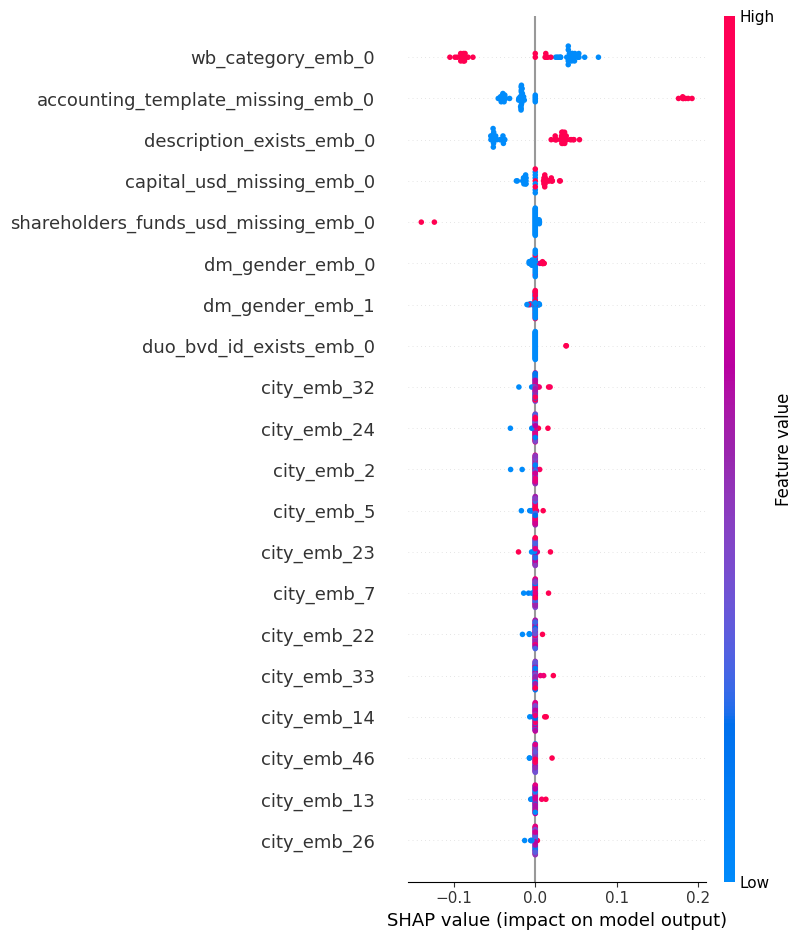

In [ ]:
# Step 7: Save results as CSV (support both list and 3D array)
if isinstance(shap_values, list):
    for i, class_shap in enumerate(shap_values):
        pd.DataFrame(class_shap, columns=feature_names).to_csv(
            f"/content/drive/MyDrive/ERP/CNN/shap_values_cnn_cls_class{i}.csv", index=False
        )
elif isinstance(shap_values, np.ndarray) and shap_values.ndim == 3:
    for i in range(shap_values.shape[2]):
        pd.DataFrame(shap_values[:, :, i], columns=feature_names).to_csv(
            f"/content/drive/MyDrive/ERP/CNN/shap_values_cnn_cls_class{i}.csv", index=False
        )

pd.DataFrame(explanation_data, columns=feature_names).to_csv(
    "/content/drive/MyDrive/ERP/CNN/shap_input_cnn_cls_full.csv", index=False
)

# Step 8: Visualize SHAP summary (use class 1 if available)
if isinstance(shap_values, list):
    shap.summary_plot(shap_values[1], features=explanation_data, feature_names=feature_names)
elif isinstance(shap_values, np.ndarray) and shap_values.ndim == 3:
    shap.summary_plot(shap_values[:, :, 1], features=explanation_data, feature_names=feature_names)


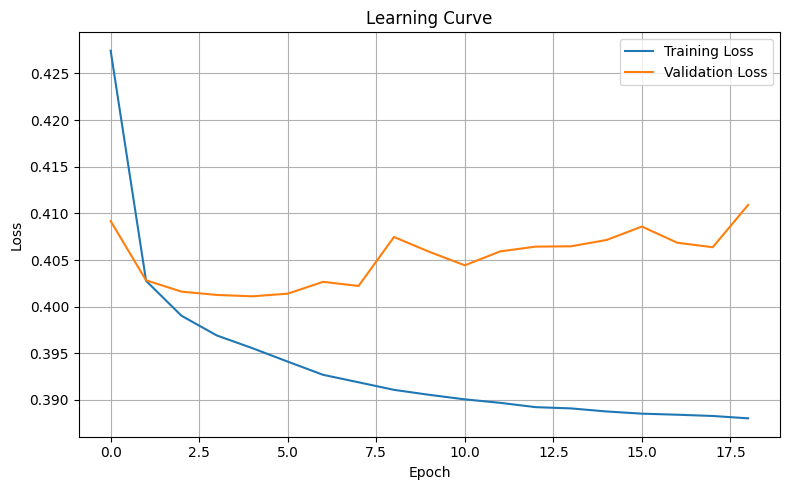

In [ ]:
# Plot learning curve
plt.figure(figsize=(8, 5))
plt.plot(train_losses, label="Training Loss")
plt.plot(val_losses, label="Validation Loss")
plt.title("Learning Curve")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
# Combine everything into a nice table
results_cls_df = pd.DataFrame({
    "true_label": y_val_cls,
    "predicted_label": predicted_labels,
    "probability_0": prob_0,   # loan_status = 0
    "probability_1": prob_1    # loan_status = 1
})

# Preview
results_cls_df.to_csv("/content/drive/MyDrive/ERP/CNN/classification_results.csv")
results_cls_df

,true_label,predicted_label,probability_0,probability_1
0,0,0,0.772065,0.227935
1,0,0,0.999962,0.000038
2,0,0,0.710655,0.289345
3,0,0,0.729963,0.270037
4,0,0,0.999961,0.000039
...,...,...,...,...
71533,0,0,0.760338,0.239662
71534,1,0,0.770452,0.229548
71535,0,0,0.796065,0.203935
71536,0,0,0.660412,0.339588


## 5. Evaluate the model


--- Evaluation on Training Data ---
AUC-ROC:     0.7547
F1-Score:    0.3304
Precision:   0.3846
Recall:      0.2897
Confusion Matrix:
[[244998  28139]
 [ 43122  17585]]
Mean G-Mean: 0.5097


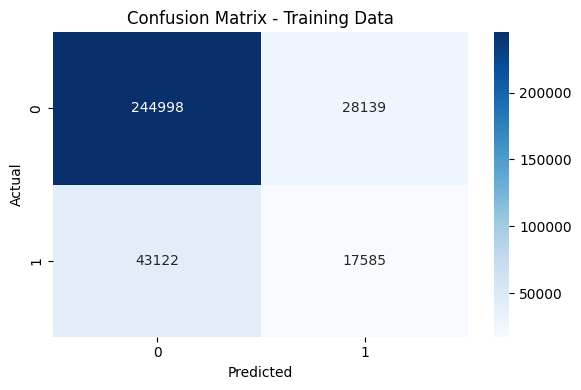


--- Evaluation on Validation Data ---
AUC-ROC:     0.7349
F1-Score:    0.3049
Precision:   0.3543
Recall:      0.2676
Confusion Matrix:
[[52182  6345]
 [ 9529  3482]]
Mean G-Mean: 0.4885


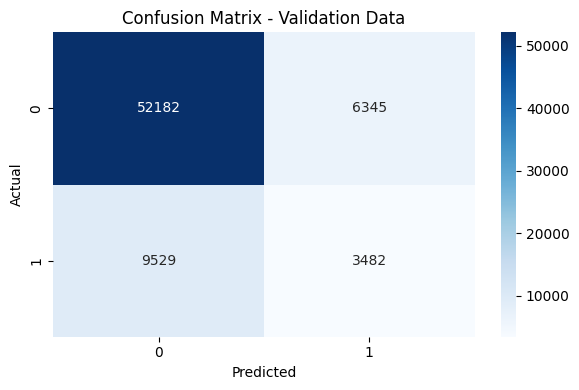


--- Evaluation on Test Data ---
AUC-ROC:     0.7386
F1-Score:    0.3049
Precision:   0.3504
Recall:      0.2699
Confusion Matrix:
[[52109  6479]
 [ 9455  3495]]
Mean G-Mean: 0.4899


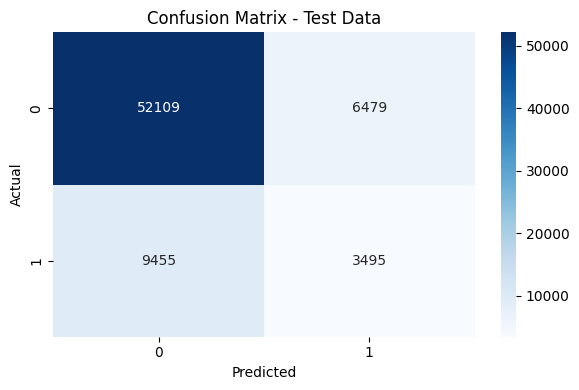

In [20]:
# === Step 5: Evaluation Metrics ===
test_loader = DataLoader(test_dataset_cls, batch_size=batch_size)

def evaluate_model(model, data_loader, dataset_name="", threshold=0.3):
    model.eval()
    y_true, y_pred, y_prob = [], [], []

    with torch.no_grad():
        for x_cat, x_num, y_batch in data_loader:
            outputs = model(x_cat, x_num)
            probs = torch.softmax(outputs, dim=1)[:, 1]
            preds = (probs > threshold).int()
            y_true.extend(y_batch.numpy())
            y_pred.extend(preds.numpy())
            y_prob.extend(probs.numpy())

    auc = roc_auc_score(y_true, y_prob)
    f1 = f1_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    conf_matrix = confusion_matrix(y_true, y_pred)
    tn, fp, fn, tp = conf_matrix.ravel()
    tpr = tp / (tp + fn + 1e-6)
    tnr = tn / (tn + fp + 1e-6)
    gmean = np.sqrt(tpr * tnr)

    print(f"\n--- Evaluation on {dataset_name} ---")
    print(f"AUC-ROC:     {auc:.4f}")
    print(f"F1-Score:    {f1:.4f}")
    print(f"Precision:   {precision:.4f}")
    print(f"Recall:      {recall:.4f}")
    print("Confusion Matrix:")
    print(conf_matrix)
    print(f"Mean G-Mean: {gmean:.4f}")

    plt.figure(figsize=(6, 4))
    sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues")
    plt.title(f"Confusion Matrix - {dataset_name}")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.tight_layout()
    plt.show()

# Run on both datasets
evaluate_model(model, train_loader, "Training Data")
evaluate_model(model, val_loader, "Validation Data")
evaluate_model(model, test_loader, "Test Data")


--- Evaluation on Test Data @ 0.3 ---
AUC-ROC:     0.7416
F1-Score:    0.3599
Precision:   0.3407
Recall:      0.3815
Confusion Matrix:
[[49029  9559]
 [ 8010  4940]]
Mean G-Mean: 0.5650


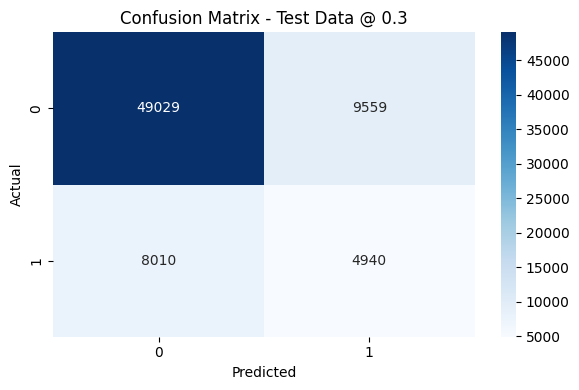


--- Evaluation on Test Data @ 0.5 ---
AUC-ROC:     0.7416
F1-Score:    0.0514
Precision:   0.4875
Recall:      0.0271
Confusion Matrix:
[[58219   369]
 [12599   351]]
Mean G-Mean: 0.1641


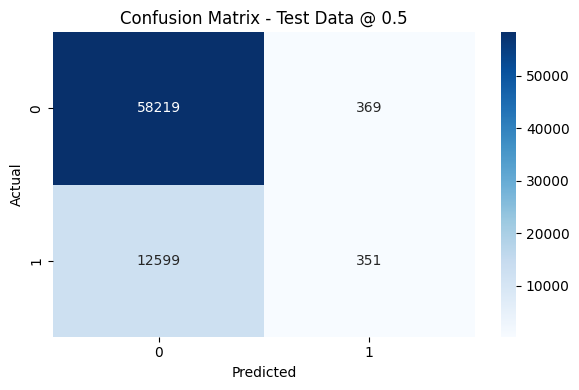


--- Evaluation on Test Data @ 0.1 ---
AUC-ROC:     0.7416
F1-Score:    0.4091
Precision:   0.2582
Recall:      0.9848
Confusion Matrix:
[[21943 36645]
 [  197 12753]]
Mean G-Mean: 0.6073


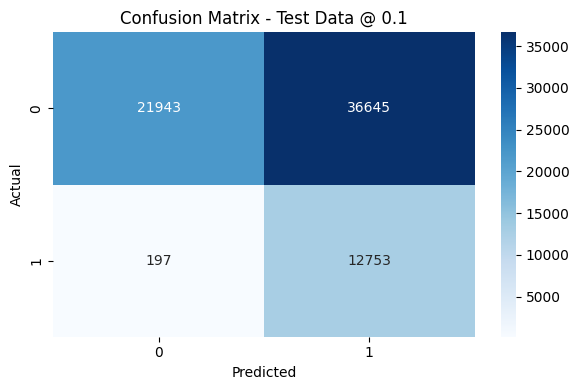

In [ ]:
# Run on test set with different thresholds
evaluate_model(model, test_loader, "Test Data @ 0.3", threshold=0.3)
evaluate_model(model, test_loader, "Test Data @ 0.5", threshold=0.5)
evaluate_model(model, test_loader, "Test Data @ 0.1", threshold=0.1)

## 6. Save the model

In [ ]:
# === Step 6: Save Model and Scaler ===
# Save both model weights and best_params dictionary
torch.save({
    'model_state_dict': model.state_dict(),
    'model_params': best_params_cls
}, "CNN_model_cls_full.pth")

# Convert dict to DataFrame (1 row)
params_df = pd.DataFrame([best_params_cls])

# Save to CSV
params_df.to_csv("/content/drive/MyDrive/ERP/CNN/best_params_cls.csv", index=False)

# Save scaler used for input normalization
#joblib.dump(scaler, "scaler.pkl")

## Optional: load the model

In [ ]:
'''
# === Optional: Load Model and Scaler Later ===
# Read CSV back into dict
loaded_params_df = pd.read_csv("best_params.csv")
best_params_cls = loaded_params_df.iloc[0].to_dict()

# Convert float strings to actual int if needed
# (because CSV stores all as float by default)
best_params_cls['hidden_size'] = int(best_params_cls['hidden_size'])
best_params_cls['num_layers'] = int(best_params_cls['num_layers'])
best_params_cls['batch_size'] = int(best_params_cls['batch_size'])
'''

In [18]:
# 1. load file
checkpoint = torch.load("/content/drive/MyDrive/ERP/CNN/CNN_model_cls_full.pth", map_location='cpu')

# 2. load contents
state_dict = checkpoint['model_state_dict']
best_params_cls = checkpoint['model_params']